In [1]:
import sys
import os
sys.path.append(os.path.abspath('../..')) # include top level package in python path

In [2]:
import torch
from comparison.examples.vae_toy import VAE_Toy
from comparison.loss import ELBO_loss, IWAE_loss
from tqdm.notebook import tqdm

In [3]:
# Change device as needed. 
# CPU is supported on all machines, CUDA for specific GPUs.

# device = 'cpu'
device = 'cuda'

In [4]:
def train(model, optim, dataloader, no_epochs=3):
    model.train()
    
    train_loss = []
    for epoch in range(1, no_epochs + 1):
        for xs in tqdm(dataloader, desc="Training Epoch №%s" % epoch, leave=False):
            xs = xs.to(device)
            vae_res = model(xs, M=10, K=10)
            loss = -ELBO_loss(vae_res)
            train_loss.append(loss.item())

            optim.zero_grad()
            loss.backward()
            optim.step()

    return torch.Tensor(train_loss)

In [5]:
model = VAE_Toy(D=20).to(device)
optim = torch.optim.Adam(model.parameters(), lr=1e-2)

In [6]:
from torch.utils.data import Dataset, DataLoader

class DistDataset(Dataset):
    def __init__(self, dist, N, device=device):
        self.samples = dist.sample(torch.Size([N])).to(device)

    def __len__(self):
        return self.samples.size(dim=0)

    def __getitem__(self, idx):
        return self.samples[idx]

In [7]:
ds = DistDataset(torch.distributions.normal.Normal(torch.zeros(20) + 2., torch.ones(20)), 1024)

In [8]:
train_loader = DataLoader(ds, batch_size=128, shuffle=True)

In [9]:
losses = train(model, optim, train_loader, 50)

In [10]:
model.mu

Parameter containing:
tensor([1.9081, 1.9818, 1.9827, 1.9891, 2.0548, 1.9647, 1.9790, 1.9831, 1.9217,
        1.9977, 1.9496, 1.9592, 1.9246, 1.9956, 1.9651, 1.9955, 1.9751, 1.9232,
        2.0173, 1.9750], device='cuda:0', requires_grad=True)

In [11]:
list(model.encode_params())

[Parameter containing:
 tensor([[ 9.6093e-01, -1.3150e-03, -5.5816e-03,  9.8870e-04, -4.1463e-03,
          -3.1046e-03, -7.0589e-04, -9.5817e-09, -3.6242e-03, -4.3319e-03,
           3.6244e-04,  1.7034e-03,  2.9677e-03, -4.1957e-03, -4.2937e-04,
           5.1100e-03,  3.0400e-03,  6.1590e-04,  1.6072e-03, -5.6244e-04],
         [-4.0649e-03,  9.8082e-01, -5.0906e-03, -5.8679e-03, -6.3040e-03,
          -4.4381e-03, -4.8408e-03, -3.3975e-03, -6.1251e-03, -4.8416e-03,
          -5.6965e-03, -2.5769e-03, -5.5868e-03, -5.3064e-03, -4.5552e-03,
          -4.0222e-03, -5.1408e-03, -4.9459e-03, -5.5769e-03, -2.5347e-03],
         [-5.5125e-03, -7.0413e-03,  9.8458e-01, -5.2460e-03, -5.3756e-03,
          -4.8993e-03, -5.6398e-03, -3.4509e-03, -4.2066e-03, -5.6838e-03,
          -6.2285e-03, -3.1021e-03, -7.4437e-03, -6.1380e-03, -5.4215e-03,
          -5.2962e-03, -3.9425e-03, -6.7069e-03, -4.4522e-03, -2.7336e-03],
         [-1.8260e-03, -2.4514e-02,  1.2260e-02,  9.3172e-01, -1.5262e-02,

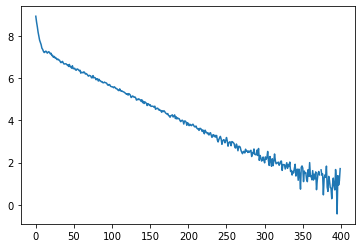

In [12]:
import matplotlib.pyplot as plt

plt.plot(torch.log(losses - min(losses)))

In [44]:
from comparison.metric import sample_grads
from comparison.loss import ELBO

grads = sample_grads(model, train_loader, tuple(model.encode_params()), M=10, K=10, loss_fn=ELBO_loss, reshape=True)

torch.Size([1024, 20, 20])
torch.Size([1024, 20])


In [45]:
def norm_over(xs: torch.Tensor, dim: int = None) -> torch.Tensor:
    if dim == None:
        return torch.sqrt((xs ** 2).sum())
    else:
        return torch.sqrt((xs ** 2).sum(dim=dim))

exp = grads.mean(dim=0)
norm_exp = exp / norm_over(exp)

In [46]:
grads_pll = ((grads * norm_exp).sum(dim=1).unsqueeze(dim=-1) * norm_exp)

In [47]:
grads_pll

tensor([[ 8.7346,  1.8205,  2.2034,  ..., -1.6937, -0.7149,  1.6760],
        [-3.4649, -0.7222, -0.8741,  ...,  0.6719,  0.2836, -0.6648],
        [ 7.4351,  1.5496,  1.8756,  ..., -1.4417, -0.6086,  1.4266],
        ...,
        [ 0.8983,  0.1872,  0.2266,  ..., -0.1742, -0.0735,  0.1724],
        [26.3549,  5.4929,  6.6483,  ..., -5.1103, -2.1572,  5.0568],
        [ 8.0119,  1.6698,  2.0211,  ..., -1.5535, -0.6558,  1.5373]],
       device='cuda:0')

In [48]:
grads

tensor([[-27.6363, -39.8715, -38.5775,  ...,   2.5858,   7.0058,   2.1349],
        [  3.8985,   0.6560,   3.5311,  ..., -18.8759,  -3.3713,  -4.6693],
        [-16.9931, -27.8445, -21.0327,  ...,  -3.8756,  -6.6125,   1.7008],
        ...,
        [-16.8503, -20.6113,  -7.3666,  ...,  -0.2008,  -0.9159, -16.4401],
        [ 21.7453,  22.6552,  33.1230,  ...,  -6.2591,  -0.1092,  11.7769],
        [  9.2279,  19.3187,  20.5734,  ...,  -4.6138,   1.1262,   3.1914]],
       device='cuda:0')

In [51]:
grads_perp = grads - grads_pll

In [52]:
dsnr = norm_over(grads_pll, dim=1) / norm_over(grads_perp, dim=1)

In [53]:
dsnr.mean()

tensor(0.1693, device='cuda:0')